In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
import time
import importlib
import pandas as pd
import numpy as np
import pickle
import cnn_p2 as cnn  
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
importlib.reload(cnn)

<module 'cnn_p2' from '/Users/sunluzhe/Desktop/LearningInUchicago/2022SpringQuarter/Machine Learning/hw/hw5/codequestion/cnn_p2.py'>

# Part 1

### You will implement the following CNN network from scratch
- The following **optional** code is from the [CNN tutorial at PyTorch](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html).  It illustrates how the network is specified in PyTorch, and counts the number of parameters.  You will have to install PyTorch for it to work.

In [2]:
#
# This is OPTIONAL code.  It will not run unless
# PyTorch is installed.
#

import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()

def count_parameters(model):
    total_params = 0
    print(f"The number of trainable params in each layer:")
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        print('  ', name, f'{params:,d}')
        total_params+=params
    print(f"Total trainable params: {total_params:,d}")
    return total_params
    
count_parameters(net)

The number of trainable params in each layer:
   conv1.weight 450
   conv1.bias 6
   conv2.weight 2,400
   conv2.bias 16
   fc1.weight 48,000
   fc1.bias 120
   fc2.weight 10,080
   fc2.bias 84
   fc3.weight 840
   fc3.bias 10
Total trainable params: 62,006


62006

### Below are test cases to help you debug the Conv, MaxPool and Flatten
- For HW5, you will also rely on other Operation Classes (VDot, Softmax, Log, etc) that you have implemented in HW4.

In [3]:
class FailTestError(Exception):
    pass

input_tensor = cnn.InputValue(np.arange(4*4*2).reshape((4,4,2)))
conv1 = cnn.InputValue(np.arange(3*3*2*4).reshape((3,3,2,4)))
bias1 = cnn.InputValue(np.arange(4))
v1 = cnn.InputValue(np.arange(16))

In [4]:
# Test Conv
x = cnn.Add(input_tensor, input_tensor)
y = cnn.Conv(x, conv1, 1, 0)
z = cnn.Add(y, bias1)
for component in [x,y,z]:
    component.forward()
z.grad = np.ones_like(z.value)
for component in [x, y, conv1, bias1]:
    component.grad = 0
for component in [z,y,x]:
    component.backward()

yvalue = np.array([[[17880., 18258., 18636., 19014.],
                    [20328., 20778., 21228., 21678.]],

                   [[27672., 28338., 29004., 29670.],
                    [30120., 30858., 31596., 32334.]]])
y_kernel_grad = np.array([[[[ 40.,  40.,  40.,  40.],
                             [ 48.,  48.,  48.,  48.]],

                            [[ 56.,  56.,  56.,  56.],
                             [ 64.,  64.,  64.,  64.]],

                            [[ 72.,  72.,  72.,  72.],
                             [ 80.,  80.,  80.,  80.]]],


                           [[[104., 104., 104., 104.],
                             [112., 112., 112., 112.]],

                            [[120., 120., 120., 120.],
                             [128., 128., 128., 128.]],

                            [[136., 136., 136., 136.],
                             [144., 144., 144., 144.]]],


                           [[[168., 168., 168., 168.],
                             [176., 176., 176., 176.]],

                            [[184., 184., 184., 184.],
                             [192., 192., 192., 192.]],

                            [[200., 200., 200., 200.],
                             [208., 208., 208., 208.]]]])
y_inputtensor_grad = np.array([[[  6.,  22.],
                                [ 44.,  76.],
                                [108., 140.],
                                [ 70.,  86.]],

                               [[108., 140.],
                                [280., 344.],
                                [408., 472.],
                                [236., 268.]],

                               [[300., 332.],
                                [664., 728.],
                                [792., 856.],
                                [428., 460.]],

                               [[198., 214.],
                                [428., 460.],
                                [492., 524.],
                                [262., 278.]]])

if not np.array_equal(y.value, yvalue):
    raise FailTestError("The output of Conv is incorrect")
if not np.array_equal(y.kernel.grad, y_kernel_grad):
    raise FailTestError("The gradient of kernel in Conv is incorrect")
if not np.array_equal(y.input_tensor.grad, y_inputtensor_grad):
    raise FailTestError("The gradient of input_tensor in Conv is incorrect")
print("Passed test on Conv with default settings")

Passed test on Conv with default settings


In [5]:
# Additional Test Conv
m1 = cnn.InputValue(np.arange(2*2*4).reshape((2,2,4)))
x = cnn.Add(input_tensor, input_tensor)
y = cnn.Conv(x, conv1, 1, 0)
z = cnn.Add(y, bias1)
u = cnn.Mul(z, m1)
for component in [x,y,z,u]:
    component.forward()
u.grad = np.ones_like(u.value)
for component in [x, y, z, conv1, bias1]:
    component.grad = 0
for component in [u,z,y,x]:
    component.backward()

yvalue = np.array([[[17880., 18258., 18636., 19014.],
                    [20328., 20778., 21228., 21678.]],

                   [[27672., 28338., 29004., 29670.],
                    [30120., 30858., 31596., 32334.]]])
y_kernel_grad = np.array([[[[ 384.,  424.,  464.,  504.],
                             [ 432.,  480.,  528.,  576.]],

                            [[ 480.,  536.,  592.,  648.],
                             [ 528.,  592.,  656.,  720.]],

                            [[ 576.,  648.,  720.,  792.],
                             [ 624.,  704.,  784.,  864.]]],


                           [[[ 768.,  872.,  976., 1080.],
                             [ 816.,  928., 1040., 1152.]],

                            [[ 864.,  984., 1104., 1224.],
                             [ 912., 1040., 1168., 1296.]],

                            [[ 960., 1096., 1232., 1368.],
                             [1008., 1152., 1296., 1440.]]],


                           [[[1152., 1320., 1488., 1656.],
                             [1200., 1376., 1552., 1728.]],

                            [[1248., 1432., 1616., 1800.],
                             [1296., 1488., 1680., 1872.]],

                            [[1344., 1544., 1744., 1944.],
                             [1392., 1600., 1808., 2016.]]]])
y_inputtensor_grad = np.array([[[  14.,   38.],
                                [ 100.,  212.],
                                [ 324.,  436.],
                                [ 390.,  478.]],

                               [[ 220.,  396.],
                                [1224., 1704.],
                                [2184., 2664.],
                                [1868., 2172.]],

                               [[1276., 1452.],
                                [4104., 4584.],
                                [5064., 5544.],
                                [3692., 3996.]],

                               [[1886., 2038.],
                                [4868., 5236.],
                                [5604., 5972.],
                                [3542., 3758.]]])

if not np.array_equal(y.value, yvalue):
    raise FailTestError("The output of Conv is incorrect")
if not np.array_equal(y.kernel.grad, y_kernel_grad):
    raise FailTestError("The gradient of kernel in Conv is incorrect")
if not np.array_equal(y.input_tensor.grad, y_inputtensor_grad):
    raise FailTestError("The gradient of input_tensor in Conv is incorrect")
print("Extra Credit: Passed Test on Conv")

Extra Credit: Passed Test on Conv


In [6]:
# For Full Credit: Conv with stride 1
x = cnn.Add(input_tensor, input_tensor)
y = cnn.Conv(x, conv1, 1, 1)
z = cnn.Add(y, bias1)
for component in [x,y,z]:
    component.forward()
z.grad = np.ones_like(z.value)
for component in [x, y, conv1, bias1]:
    component.grad = 0
for component in [z,y,x]:
    component.backward()

yvalue = np.array([[[ 5248.,  5336.,  5424.,  5512.],
                    [ 8608.,  8764.,  8920.,  9076.],
                    [10816., 11020., 11224., 11428.],
                    [ 7232.,  7384.,  7536.,  7688.]],

                   [[11856., 12084., 12312., 12540.],
                    [17880., 18258., 18636., 19014.],
                    [20328., 20778., 21228., 21678.],
                    [12912., 13236., 13560., 13884.]],

                   [[19152., 19572., 19992., 20412.],
                    [27672., 28338., 29004., 29670.],
                    [30120., 30858., 31596., 32334.],
                    [18672., 19188., 19704., 20220.]],

                   [[ 9792., 10136., 10480., 10824.],
                    [13312., 13852., 14392., 14932.],
                    [14368., 14956., 15544., 16132.],
                    [ 8192.,  8600.,  9008.,  9416.]]])
y_kernel_grad = np.array([[[[180., 180., 180., 180.],
                         [198., 198., 198., 198.]],

                        [[264., 264., 264., 264.],
                         [288., 288., 288., 288.]],

                        [[216., 216., 216., 216.],
                         [234., 234., 234., 234.]]],


                       [[[336., 336., 336., 336.],
                         [360., 360., 360., 360.]],

                        [[480., 480., 480., 480.],
                         [512., 512., 512., 512.]],

                        [[384., 384., 384., 384.],
                         [408., 408., 408., 408.]]],


                       [[[324., 324., 324., 324.],
                         [342., 342., 342., 342.]],

                        [[456., 456., 456., 456.],
                         [480., 480., 480., 480.]],

                        [[360., 360., 360., 360.],
                         [378., 378., 378., 378.]]]])
y_inputtensor_grad = np.array([[[ 280.,  344.],
                                [ 516.,  612.],
                                [ 516.,  612.],
                                [ 408.,  472.]],

                               [[ 708.,  804.],
                                [1206., 1350.],
                                [1206., 1350.],
                                [ 900.,  996.]],

                               [[ 708.,  804.],
                                [1206., 1350.],
                                [1206., 1350.],
                                [ 900.,  996.]],

                               [[ 664.,  728.],
                                [1092., 1188.],
                                [1092., 1188.],
                                [ 792.,  856.]]])

if not np.array_equal(y.value, yvalue):
    raise FailTestError("The output of Conv is incorrect")
if not np.array_equal(y.kernel.grad, y_kernel_grad):
    raise FailTestError("The gradient of kernel in Conv is incorrect")
if not np.array_equal(y.input_tensor.grad, y_inputtensor_grad):
    raise FailTestError("The gradient of input_tensor in Conv is incorrect")
print("Passed Test on Conv with stride 1")

Passed Test on Conv with stride 1


In [7]:
# For Full Credit: Conv with stride 2 and padding 1
x = cnn.Add(input_tensor, input_tensor)
y = cnn.Conv(x, conv1, 2, 1)
z = cnn.Add(y, bias1)
for component in [x,y,z]:
    component.forward()
z.grad = np.ones_like(z.value)
for component in [x, y, conv1, bias1]:
    component.grad = 0
for component in [z,y,x]:
    component.backward()

yvalue = np.array([[[ 5248.,  5336.,  5424.,  5512.],
                    [10816., 11020., 11224., 11428.]],

                   [[19152., 19572., 19992., 20412.],
                    [30120., 30858., 31596., 32334.]]])
y_kernel_grad = np.array([[[[ 20.,  20.,  20.,  20.],
                             [ 22.,  22.,  22.,  22.]],

                            [[ 40.,  40.,  40.,  40.],
                             [ 44.,  44.,  44.,  44.]],

                            [[ 48.,  48.,  48.,  48.],
                             [ 52.,  52.,  52.,  52.]]],


                           [[[ 40.,  40.,  40.,  40.],
                             [ 44.,  44.,  44.,  44.]],

                            [[ 80.,  80.,  80.,  80.],
                             [ 88.,  88.,  88.,  88.]],

                            [[ 96.,  96.,  96.,  96.],
                             [104., 104., 104., 104.]]],


                           [[[ 72.,  72.,  72.,  72.],
                             [ 76.,  76.,  76.,  76.]],

                            [[144., 144., 144., 144.],
                             [152., 152., 152., 152.]],

                            [[160., 160., 160., 160.],
                             [168., 168., 168., 168.]]]])
y_inputtensor_grad = np.array([[[134., 150.],
                                [268., 300.],
                                [134., 150.],
                                [166., 182.]],

                               [[268., 300.],
                                [536., 600.],
                                [268., 300.],
                                [332., 364.]],

                               [[134., 150.],
                                [268., 300.],
                                [134., 150.],
                                [166., 182.]],

                               [[230., 246.],
                                [460., 492.],
                                [230., 246.],
                                [262., 278.]]])

if not np.array_equal(y.value, yvalue):
    raise FailTestError("The output of Conv is incorrect")
if not np.array_equal(y.kernel.grad, y_kernel_grad):
    raise FailTestError("The gradient of kernel in Conv is incorrect")
if not np.array_equal(y.input_tensor.grad, y_inputtensor_grad):
    raise FailTestError("The gradient of input_tensor in Conv is incorrect")
print("Passed Test on Conv with stride 2 and padding 1")

Passed Test on Conv with stride 2 and padding 1


In [8]:
# Test MaxPool
x = cnn.Add(input_tensor, input_tensor)
y = cnn.Conv(x, conv1, 1, 1)
z = cnn.Add(y, bias1)
u = cnn.RELU(z)
v = cnn.MaxPool(u, 2)
for component in [x,y,z,u,v]:
    component.forward()
v.grad = np.ones_like(v.value)
for component in [x,y,z,u, conv1, bias1]:
    component.grad = 0
for component in [v,u,z,y,x]:
    component.backward()

vvalue = np.array([[[17880., 18259., 18638., 19017.],
                    [20328., 20779., 21230., 21681.]],
                   [[27672., 28339., 29006., 29673.],
                    [30120., 30859., 31598., 32337.]]])
v_inputtensor_grad = np.array([[[0., 0., 0., 0.],
                                [0., 0., 0., 0.],
                                [0., 0., 0., 0.],
                                [0., 0., 0., 0.]],

                               [[0., 0., 0., 0.],
                                [1., 1., 1., 1.],
                                [1., 1., 1., 1.],
                                [0., 0., 0., 0.]],

                               [[0., 0., 0., 0.],
                                [1., 1., 1., 1.],
                                [1., 1., 1., 1.],
                                [0., 0., 0., 0.]],

                               [[0., 0., 0., 0.],
                                [0., 0., 0., 0.],
                                [0., 0., 0., 0.],
                                [0., 0., 0., 0.]]])

if not np.array_equal(v.value, vvalue):
    raise FailTestError("The output of MaxPool is incorrect")
if not np.array_equal(v.input_tensor.grad, v_inputtensor_grad):
    raise FailTestError("The gradient of input_tensor in MaxPool is incorrect")
print("Passed Test on MaxPool")

Passed Test on MaxPool


In [9]:
# Additional Test MaxPool
m2 = cnn.InputValue(np.arange(2*2*4).reshape((2,2,4)))
x = cnn.Add(input_tensor, input_tensor)
y = cnn.Conv(x, conv1, 1, 1)
z = cnn.Add(y, bias1)
u = cnn.RELU(z)
v = cnn.MaxPool(u, 2)
w = cnn.Mul(v, m2)
for component in [x,y,z,u,v,w]:
    component.forward()
w.grad = np.ones_like(w.value)
for component in [x,y,z,u,v,conv1, bias1]:
    component.grad = 0
for component in [w,v,u,z,y,x]:
    component.backward()

vvalue = np.array([[[17880., 18259., 18638., 19017.],
                    [20328., 20779., 21230., 21681.]],
                   [[27672., 28339., 29006., 29673.],
                    [30120., 30859., 31598., 32337.]]])
v_inputtensor_grad = np.array([[[ 0.,  0.,  0.,  0.],
                                [ 0.,  0.,  0.,  0.],
                                [ 0.,  0.,  0.,  0.],
                                [ 0.,  0.,  0.,  0.]],

                               [[ 0.,  0.,  0.,  0.],
                                [ 0.,  1.,  2.,  3.],
                                [ 4.,  5.,  6.,  7.],
                                [ 0.,  0.,  0.,  0.]],

                               [[ 0.,  0.,  0.,  0.],
                                [ 8.,  9., 10., 11.],
                                [12., 13., 14., 15.],
                                [ 0.,  0.,  0.,  0.]],

                               [[ 0.,  0.,  0.,  0.],
                                [ 0.,  0.,  0.,  0.],
                                [ 0.,  0.,  0.,  0.],
                                [ 0.,  0.,  0.,  0.]]])

if not np.array_equal(v.value, vvalue):
    raise FailTestError("The output of MaxPool is incorrect")
if not np.array_equal(v.input_tensor.grad, v_inputtensor_grad):
    raise FailTestError("The gradient of input_tensor in MaxPool is incorrect")
print("Passed Additional Test on MaxPool")

Passed Additional Test on MaxPool


In [10]:
# For Full Credit: Test MaxPool with non-default stride
x = cnn.Add(input_tensor, input_tensor)
y = cnn.Conv(x, conv1, 1, 1)
z = cnn.Add(y, bias1)
u = cnn.RELU(z)
v = cnn.MaxPool(u, 4, stride=4)
for component in [x,y,z,u,v]:
    component.forward()
v.grad = np.ones_like(v.value)
for component in [x,y,z,u, conv1, bias1]:
    component.grad = 0
for component in [v,u,z,y,x]:
    component.backward()

vvalue = np.array([[[30120., 30859., 31598., 32337.]]])
v_inputtensor_grad = np.array([[[0., 0., 0., 0.],
                                [0., 0., 0., 0.],
                                [0., 0., 0., 0.],
                                [0., 0., 0., 0.]],

                               [[0., 0., 0., 0.],
                                [0., 0., 0., 0.],
                                [0., 0., 0., 0.],
                                [0., 0., 0., 0.]],

                               [[0., 0., 0., 0.],
                                [0., 0., 0., 0.],
                                [1., 1., 1., 1.],
                                [0., 0., 0., 0.]],

                               [[0., 0., 0., 0.],
                                [0., 0., 0., 0.],
                                [0., 0., 0., 0.],
                                [0., 0., 0., 0.]]])

if not np.array_equal(v.value, vvalue):
    raise FailTestError("The output of MaxPool is incorrect")
if not np.array_equal(v.input_tensor.grad, v_inputtensor_grad):
    raise FailTestError("The gradient of input_tensor in MaxPool is incorrect")
print("Passed Test on MaxPool with non-default stride")

Passed Test on MaxPool with non-default stride


In [11]:
# Test Flatten
x = cnn.Add(input_tensor, input_tensor)
y = cnn.Conv(x, conv1, 1, 1)
z = cnn.Add(y, bias1)
u = cnn.RELU(z)
v = cnn.MaxPool(u, 2)
w = cnn.Flatten(v)
o = cnn.Mul(w, v1)
for component in [x,y,z,u,v,w,o]:
    component.forward()
o.grad = np.ones_like(o.value)
for component in [x,y,z,u,v,w,conv1, bias1]:
    component.grad = 0
for component in [o,w,v,u,z,y,x]:
    component.backward()

wvalue = np.array([17880., 18259., 18638., 19017., 20328., 20779., 21230., 21681.,
       27672., 28339., 29006., 29673., 30120., 30859., 31598., 32337.])
w_inputtensor_grad = np.array([[[ 0.,  1.,  2.,  3.],
        [ 4.,  5.,  6.,  7.]],

       [[ 8.,  9., 10., 11.],
        [12., 13., 14., 15.]]])

if not np.array_equal(w.value, wvalue):
    raise FailTestError("The output of Flatten is incorrect")
if not np.array_equal(w.input_tensor.grad, w_inputtensor_grad):
    raise FailTestError("The gradient of input_tensor in Flatten is incorrect")
print("Passed Test on Flatten")

Passed Test on Flatten


In [12]:
# Test ReLU

c1 = cnn.InputValue(np.sin(np.arange(3*3*4).reshape((3,3,4))).astype(np.float32))
b1 = cnn.InputValue(np.sin(np.arange(4)).astype(np.float32))
m1 = cnn.InputValue(np.cos(np.arange(3*3*4).reshape((3,3,4))).astype(np.float32))

x = cnn.Add(c1, b1)
y = cnn.RELU(x)
z = cnn.Mul(y, m1)
for component in [x,y,z]:
    component.forward()
z.grad = np.ones_like(z.value)
for component in [x,y]:
    component.grad = 0
for component in [z,y,x]:
    component.backward()

yvalue = np.array([[[0.        , 1.6829419 , 1.8185948 , 0.28224   ],
                    [0.        , 0.        , 0.6298819 , 0.7981066 ],
                    [0.98935825, 1.2535894 , 0.36527628, 0.        ]],

                   [[0.        , 1.2616379 , 1.8999047 , 0.7914079 ],
                    [0.        , 0.        , 0.15831017, 0.2909972 ],
                    [0.9129453 , 1.6781266 , 0.9004461 , 0.        ]],

                   [[0.        , 0.7091192 , 1.6718559 , 1.0974959 ],
                    [0.2709058 , 0.17783707, 0.        , 0.        ],
                    [0.5514267 , 1.8413827 , 1.4383801 , 0.        ]]], dtype=np.float32)
yagrad = np.array([[[ 0.        ,  0.5403023 , -0.41614684, -0.9899925 ],
                                [ 0.        ,  0.        ,  0.96017027,  0.75390226],
                                [-0.14550003, -0.91113025, -0.8390715 ,  0.        ]],

                               [[ 0.        ,  0.9074468 ,  0.13673721, -0.7596879 ],
                                [ 0.        ,  0.        ,  0.6603167 ,  0.9887046 ],
                                [ 0.40808207, -0.54772925, -0.99996084,  0.        ]],

                               [[ 0.        ,  0.99120283,  0.6469193 , -0.29213881],
                                [-0.9626059 , -0.74805754,  0.        ,  0.        ],
                                [ 0.8342234 , -0.01327675, -0.8485703 ,  0.        ]]],
                              dtype=np.float32)

if not np.array_equal(np.round(y.value.astype(np.float32),3), np.round(yvalue.astype(np.float32), 3)):
    raise FailTestError("The output of ReLU is incorrect")
if not np.array_equal(np.round(y.a.grad.astype(np.float32),3), np.round(yagrad.astype(np.float32), 3)):
    raise FailTestError("The gradient of input_tensor in ReLU is incorrect")
print("Passed Test on ReLU")

Passed Test on ReLU


# Part 2

### Applying to the CIFAR10 dataset
- You can refer to https://www.cs.toronto.edu/~kriz/cifar.html for details
- Labels 0 to 9 refer to the following --- 0:airplane, 1:automobile, 2:bird, 3:cat, 4:deer, 5:dog, 6:frog, 7:horse, 8:ship, 9:truck
- We will only use a subsample of 10000 images with 1000 of each class.


In [13]:
data = np.load('./cifar10_data/sub_data.npz')
X = np.float32(data['imgs'])/255.
# Reshape the valid image data to (idx, h, w, channel)
X = X.reshape(10000, 32, 32, 3)
y = np.float32(data['labels'])

# for simplicity, let's focus on the first four classes
# there are 4000 images in total
sub_idx = np.where(y<=3)[0]
X = X[sub_idx]
y = y[sub_idx]

# split in to train an test set
train_x, test_x = X[:3000], X[3000:]
train_y, test_y = y[:3000], y[3000:]

3.0


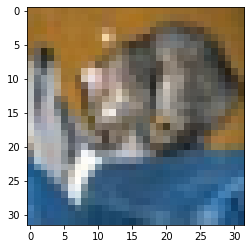

In [14]:
# below is what an image looks like
print(train_y[0])  # 3:cat
imgplot = plt.imshow(train_x[0])

### Peculiarity of the bias implementation

Before debugging the fit function please know that this framework, in particular the ``Add`` class that has been provided, is a simplified implementation, which leads to a slightly unusual implementation of the bias for the convolutional layer.

Suppose we have a convolutional layer with 6 filters that outputs an image of shape 28 x 28 x 6. In the regular implementation, the corresponding bias would be a vector of length 6.  Further given an output gradient of shape 28 x 28 x 6, the gradient of the bias would also be a vector of length 6, in which we sum the output gradients over each 28 x 28 slice.  In order to make the ``Add`` class simple and yet general, we have skipped this summation over the first two dimensions in the ``backward`` function of the ``Add`` class.  (We will likely change this in the next version.)

So for convoutional layers our implementation implicitly assumes that the bias does not involve any parameter sharing, and we have a bias term for each value of the output image.  So in the above case, we work with a bias of shape 28 x 28 x 6.  (This could potentially increase the number of epochs required for convergence, but fortunately it does not in this homework.)

Further, even if you do set the bias to, say 6, instead of 28 x 28 x 6, the code does not throw any error as long as your ``sgd_update_parameter`` uses

`param.value = param.value - lr * param.grad`

instead of 

`param.value -= lr * param.grad`

The former works because of broadcasting.

### Debugging the fit function

In [15]:
import pickle5 as pickle
import cnn_p2 as cnn  

In [16]:
importlib.reload(cnn)  # important line so that the changes you made on cnn_p2.py will be reflected without restarting the kernel
model = cnn.CNN(num_labels=4)

# # Used to generate sample_params, don't uncomment the codes below
# model.init_params_with_xavier()
# params = model.get_param_dict()
# with open("./cifar10_data/sample_params.pkl", 'wb') as f:
#     pickle.dump(params, f, protocol=pickle.HIGHEST_PROTOCOL)

# You can use the provided sample weights for initialization to help debug
with open("./cifar10_data/sample_params.pkl", 'rb') as f:
    params = pickle.load(f)
model.set_params_by_dict(params)




# You can use the first 2 samples to test if the gradients are correct
X = train_x[:2]
y = train_y[:2]

# when calling fit, a computational graph will be built first, you should expect the exact lines printed
model.fit(X, y, alpha=0.01, t=1)

# # Used to generate sample_grad, don't uncomment the codes below
# sample_grad = {}
# for k in params.keys():
#     sample_grad[k] = model.params[k].grad
# with open("./cifar10_data/sample_grad.pkl", 'wb') as f:
#     pickle.dump(sample_grad, f, protocol=pickle.HIGHEST_PROTOCOL)

# Load the sample gradient for debugging
with open("./cifar10_data/sample_grad.pkl", 'rb') as f:
    sample_grad = pickle.load(f)
    
for k in params.keys():
    if not np.array_equal(np.round(sample_grad[k], 3), np.round(model.params[k].grad, 3)):
        raise FailTestError(f"gradient of param {k} is incorrect")
print("Congrats! You have passed the test of your fit function, your CNN model should be good to go!")


Append <Conv> to the computational graph
Append <Add> to the computational graph
Append <Conv> to the computational graph
Append <Add> to the computational graph
Append <VDot> to the computational graph
Append <Add> to the computational graph
Append <VDot> to the computational graph
Append <Add> to the computational graph
Append <VDot> to the computational graph
Append <Add> to the computational graph
Append <Aref> to the computational graph
Append <Log> to the computational graph
Append <Mul> to the computational graph
Append <Accuracy> to the computational graph


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0: train loss = 1.2277, accy = 0.5000, [0.673 secs]
Congrats! You have passed the test of your fit function, your CNN model should be good to go!


### Now train your CNN on the whole training dataset

In [17]:
importlib.reload(cnn)
model = cnn.CNN(num_labels=4)
model.init_params_with_xavier()
# It could take as much as 1 hour to train
model.fit(train_x, train_y, 0.01, 10)

Append <Conv> to the computational graph
Append <Add> to the computational graph
Append <Conv> to the computational graph
Append <Add> to the computational graph
Append <VDot> to the computational graph
Append <Add> to the computational graph
Append <VDot> to the computational graph
Append <Add> to the computational graph
Append <VDot> to the computational graph
Append <Add> to the computational graph
Append <Aref> to the computational graph
Append <Log> to the computational graph
Append <Mul> to the computational graph
Append <Accuracy> to the computational graph


  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch 0: train loss = 1.1670, accy = 0.4463, [750.427 secs]


  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch 1: train loss = 1.0072, accy = 0.5680, [754.620 secs]


  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch 2: train loss = 0.8741, accy = 0.6417, [744.736 secs]


  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch 3: train loss = 0.8541, accy = 0.6477, [734.919 secs]


  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch 4: train loss = 0.7483, accy = 0.6780, [744.972 secs]


  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch 5: train loss = 0.8185, accy = 0.6563, [752.459 secs]


  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch 6: train loss = 0.7346, accy = 0.6937, [742.679 secs]


  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch 7: train loss = 0.6211, accy = 0.7600, [754.562 secs]


  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch 8: train loss = 0.8199, accy = 0.6957, [745.423 secs]


  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch 9: train loss = 0.5273, accy = 0.7937, [750.457 secs]


In [18]:
# with 10 epochs, you should be able to achieve an accuracy of over 60%, 
# which is quite good compared with 25% of random guess
accy, loss = model.eval(test_x, test_y)
print("Test accuracy = %.4f, loss = %.4f" % (accy, loss))

Test accuracy = 0.6180, loss = 1.1251
